# Emotion detection in crowds with YOLO


In [1]:
!pip install --quiet opencv-python ultralytics
!pip install --quiet iterative-stratification

In the next cell we set-up all the directories we will use for the training process. Make sure they match your configuration.

In [2]:
import pandas as pd
import ast
import os
from pathlib import Path
from google.colab import drive
from utilsJ import *

drive.mount("/content/drive")
%cd 'drive/Othercomputers/My Computer (1)/EmotionTeller-github'

data_root       = Path('Data')                # Folder where all data sources are stored
dataset_path    = data_root/'ImageData'       # List of folders containing images in .jpg format
data_meta       = ['emotic-relabelled.csv',
                'hgel-relabelled.csv']        # List of metadata corresponding to previous list of folders in .csv format. In our case we relabelled some of the data, so this is different from original metadata.
meta_root       = Path('Metadata')            # Folder where the previous .csv files are located
yolo_dir        = Path('YOLO_training')       # Folder where the results and data splitting will take place for YOLO
os.makedirs(yolo_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/My Computer (1)/EmotionTeller-github


The metadata for the train set will be stored in the dataframe `df`.

In [3]:
df = pd.read_csv(meta_root/'train_meta.csv')
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(dataset_path/x.file_name),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_width,original_height,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


In [4]:
import cv2
from ultralytics import YOLO

Since our data is not balanced emotion-wise, we do an stratified train-val split. This will keep the same proportion of emotions in the train and validation set.

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

In [6]:
mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx = np.arange(len(df))

(train_idx, test_idx), = mss.split(idx, y)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df  = df.iloc[test_idx].reset_index(drop=True)

The emotions to be detected by the model.

In [7]:
emo_dic = {'Neutral':0,'Happy':1,'Surprise':2,'Sad':3,'Angry':4,'Fear':5,'Disgust':6}

The following two cells, create new folders with labels and pictures for our training and validation sets according the structure required by `YOLO`.

In [8]:
def xywh2xcycwh(x,y,w,h):
  return [x + w/2, y + h/2, w/2, h/2]

def label(item):
  objs = item['objects']
  text_label = ''
  for ind, emotion in enumerate(objs['categories']):
    x,y,w,h = np.array(objs['bbox'][ind])/100 # Unpack the list into four variables
    xc,yc,wc,hc = xywh2xcycwh(x,y,w,h) # Pass the four variables to the function
    text_label += f'{emo_dic[emotion]} {xc} {yc} {wc} {hc}\n'
  return text_label

To train the model, we our data needs to be in `YOLO format`. This requires a `.yaml` file which contains the relative path for the train and validation set in addition to the classes of objects to be detected. The every training image should be placed in the `images/train` folder, while the corresponding labels should be saved in a `.txt` file with the same name in the `labels/train` folder. The same thing should be done for the validation set. For example, the file structure should look like this:

```bash
YOLO_training
├─ data.yaml
├─ images
│  ├─ train
│  │  ├─image1.jpg
│  │  └─image2.jpg
│  └─ val
│     ├─image3.jpg
│     └─image4.jpg
└─ labels
   ├─ train
   │  ├─image1.txt
   │  └─image2.txt
   └─ val
      ├─image3.txt
      └─image4.txt
```

The cell below, transforms the data we have in `data_root` to the format outlined above.

In [86]:
import shutil
from tqdm import tqdm

# Create directories for train and validation images and labels
os.makedirs(yolo_dir/'images'/'train', exist_ok=True)
os.makedirs(yolo_dir/'labels'/'train', exist_ok=True)
os.makedirs(yolo_dir/'images'/'val', exist_ok=True)
os.makedirs(yolo_dir/'labels'/'val', exist_ok=True)

#for index, row in train_df.iterrows():

# Generate labels and copy images for the training set
for index, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Copying train files"):
    image_name = row['file_name']
    label_content = label(row)
    with open(yolo_dir/'labels'/'train'/image_name.replace('.jpg', '.txt'), 'w') as f:
        f.write(label_content)
    shutil.copy(dataset_path/image_name, yolo_dir/'images'/'train'/image_name)

#for index, row in test_df.iterrows():
# Generate labels and copy images for the validation set
for index, row in tqdm(val_df.iterrows(), total=len(val_df), desc="Copying validation files"):
    image_name = row['file_name']
    label_content = label(row) # FIX THIS
    with open(yolo_dir/'labels'/'val'/image_name.replace('.jpg', '.txt'), 'w') as f:
        f.write(label_content)
    shutil.copy(dataset_path/image_name, yolo_dir/'images'/'val'/image_name)

print("\n Generated label files and copied images for train and validation sets.")

Copying validation files: 100%|██████████| 36/36 [00:00<00:00, 77.79it/s]


 Generated label files and copied images for train and validation sets.


We can now proceed to train the model with the baseline configuration.

In [87]:
model = YOLO('yolo11n.pt')

name = 'yolo_baseline'

results = model.train(data = yolo_dir/'data.yaml', project= yolo_dir/"runs", name= name, imgsz=1024, epochs = 300,device=0, rect= True)

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

The plots below show the result of the training.

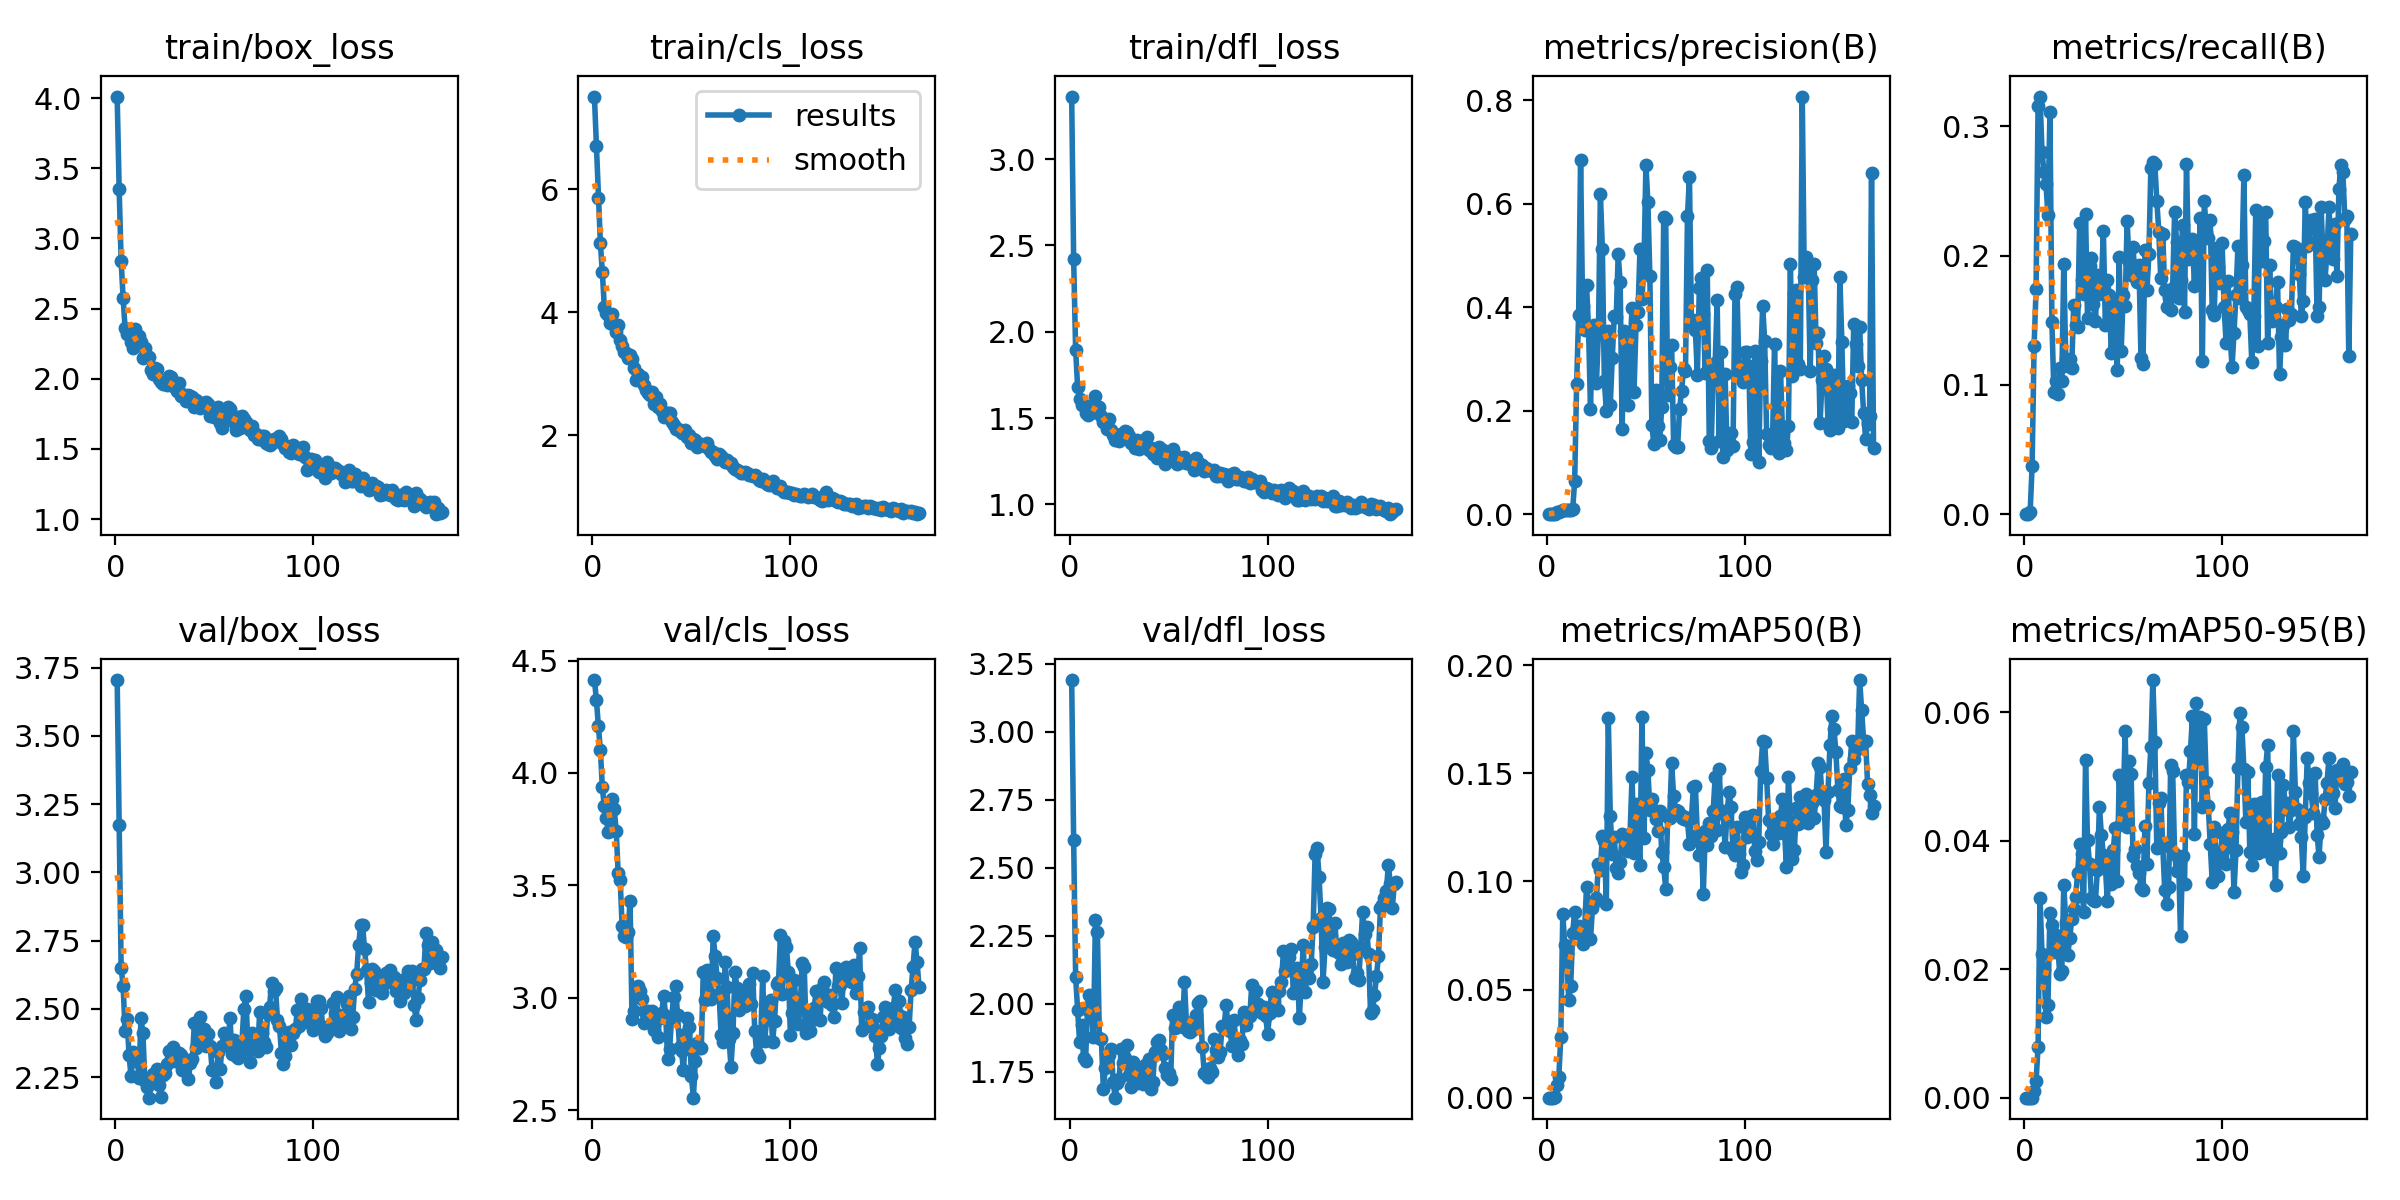

In [28]:
from IPython.display import Image, display

results_path = yolo_dir / "runs" / name / "results.png"

display(Image(filename=results_path, width=1000))

We use our model to predict on train and validation sets. Make sure you select the correct weights for the latest run.

In [10]:
fine_tuned = YOLO('YOLO_training/runs/train2/weights/best.pt')

val_df['path_to_img'] = val_df.apply(lambda x: yolo_dir/'images'/'val'/x.file_name,axis=1)

train_df['path_to_img'] = train_df.apply(lambda x: yolo_dir/'images'/'train'/x.file_name,axis=1)

train_preds = fine_tuned.predict(list(train_df['path_to_img']))
val_preds = fine_tuned.predict(list(val_df['path_to_img']))


0: 1024x1024 (no detections), 148.0ms
1: 1024x1024 1 Disgust, 148.0ms
2: 1024x1024 1 Sad, 148.0ms
3: 1024x1024 1 Sad, 1 Disgust, 148.0ms
4: 1024x1024 (no detections), 148.0ms
5: 1024x1024 1 Sad, 1 Disgust, 148.0ms
6: 1024x1024 3 Neutrals, 1 Sad, 148.0ms
7: 1024x1024 3 Neutrals, 148.0ms
8: 1024x1024 2 Neutrals, 148.0ms
9: 1024x1024 1 Disgust, 148.0ms
10: 1024x1024 1 Neutral, 1 Sad, 148.0ms
11: 1024x1024 1 Disgust, 148.0ms
12: 1024x1024 3 Neutrals, 2 Happys, 148.0ms
13: 1024x1024 1 Sad, 148.0ms
14: 1024x1024 (no detections), 148.0ms
15: 1024x1024 1 Disgust, 148.0ms
16: 1024x1024 1 Fear, 148.0ms
17: 1024x1024 1 Sad, 148.0ms
18: 1024x1024 1 Sad, 148.0ms
19: 1024x1024 1 Angry, 1 Disgust, 148.0ms
20: 1024x1024 (no detections), 148.0ms
21: 1024x1024 1 Disgust, 148.0ms
22: 1024x1024 1 Fear, 148.0ms
23: 1024x1024 1 Sad, 1 Fear, 148.0ms
24: 1024x1024 1 Fear, 148.0ms
25: 1024x1024 1 Disgust, 148.0ms
26: 1024x1024 (no detections), 148.0ms
27: 1024x1024 1 Disgust, 148.0ms
28: 1024x1024 (no detecti

To see how this compares to original labelling, set `pic_id` to any index in the training dataset and run the cell below it.

In [23]:
pic_id=40

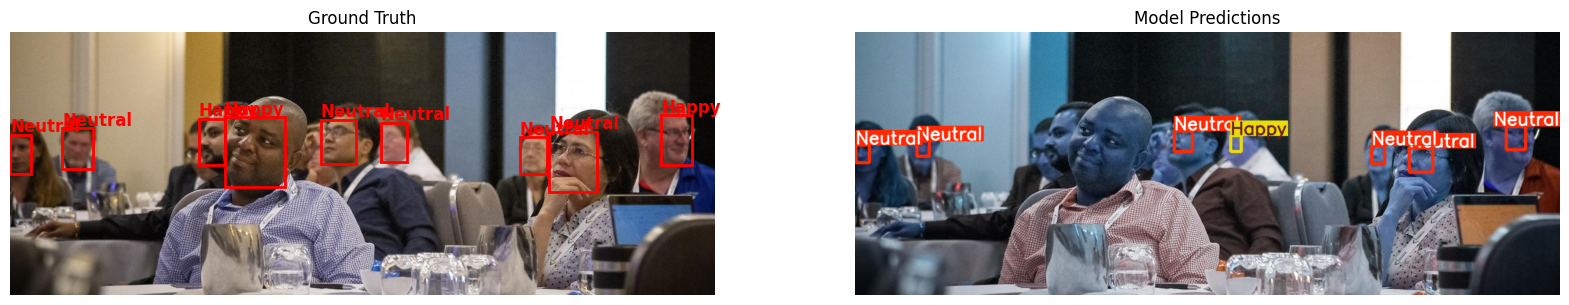

In [24]:
# @title
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

test = train_df.iloc[pic_id]

width = test['original_width']
height = test['original_height']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the original image with ground truth bounding boxes on the left subplot
axes[0].imshow(Image.open(os.path.join(yolo_dir,'images','train',test['file_name'])))
axes[0].set_title('Ground Truth')
axes[0].axis("off")

for ind, bbox in enumerate(test['objects']['bbox']):
  bbox = np.array(bbox)/100
  x, y, w, h = bbox*[width,height,width,height]

  # Create a Rectangle patch
  rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  axes[0].add_patch(rect)

  # Add the emotion label
  emotion_label = test['objects']['categories'][ind]
  axes[0].text(x, y - 5, emotion_label, color='red', fontsize=12, weight='bold')


#Display the image with model predictions on the right subplot
axes[1].imshow(train_preds[pic_id].plot(conf = False, line_width = int(width*0.003))) # YOLO's plot method returns an image
axes[1].set_title('Model Predictions')
axes[1].axis("off")

plt.show()

### Training with KFolds

Below we will create stratified KFolds and split our images to train following this [guide](https://docs.ultralytics.com/guides/kfold-cross-validation/#k-fold-dataset-split) and this [package](https://github.com/trent-b/iterative-stratification).

In [39]:
df = pd.read_csv(meta_root/'train_meta.csv')
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(data_folders/x.file_name),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_width,original_height,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


We create a dataframe whose indices are the pictures in our train set and has a column for each fold in our n-Fold Cross-Validation. The entry in each column determins if that picture belongs to the train or validation set in that corresponding fold.

In [41]:
index = list(df['file_name'])

mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

ksplit = 5

msk = MultilabelStratifiedKFold(n_splits=ksplit, shuffle=True, random_state=42)
idx = np.arange(len(df))

folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=index, columns=folds)

kfolds = list(msk.split(idx, y))

#For every image, we write if they belong to "train" or "val" in each respective fold
for i, (train_idx, val_idx) in enumerate(kfolds, start=1):
    col = f"split_{i}"
    col_pos = folds_df.columns.get_loc(col)
    folds_df.iloc[train_idx,col_pos] = "train"
    folds_df.iloc[val_idx,col_pos] = "val"



We prepare the data for each split according to the `YOLO format`.

In [44]:
import datetime
import yaml

yaml_file = yolo_dir/"data.yaml"  # your data YAML with data directories and names dictionary

with open(yaml_file, encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]

# List with image file paths
images = list(df["file_name"].apply(lambda x: dataset_path/x))

# Create the necessary directories and dataset YAML files
save_path = yolo_dir / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val"
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

We now copy each image to their respective n-Fold Cross-Validation folder.

In [45]:
for image in tqdm(images, total=len(images), desc="Copying files"):
    for split, k_split in folds_df.loc[image.name].items():
        # Destination directory
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        row = df.loc[df["file_name"] == image.name].iloc[0]
        label_content = label(row)
        with open(lbl_to_path/image.name.replace('.jpg', '.txt'), 'w') as f:
            f.write(label_content)

Copying files: 100%|██████████| 178/178 [00:11<00:00, 14.87it/s]


We now evaluate how the base YOLO model performs in n-fold cross validation.

In [46]:
results = {}

batch = 32
project = save_path/"runs"
epochs = 300
weights_path = 'yolo11n.pt'

for k, dataset_yaml in enumerate(ds_yamls):
    model = YOLO(weights_path, task="detect")
    results[k] = model.train(
        data=dataset_yaml, epochs=epochs, batch=batch, project=project, name=f"fold_{k + 1}", imgsz=1024, device=0, rect= True
    )  # include any additional train arguments

Streaming output truncated to the last 5000 lines.
                   all         35        212      0.317      0.192       0.14     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/300      12.4G      1.594      1.577       1.13         23        768: 100% ━━━━━━━━━━━━ 5/5 5.7it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 5.6it/s 0.2s
                   all         35        212      0.396       0.12      0.095     0.0297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/300      12.4G      1.662      1.569      1.148         23        768: 100% ━━━━━━━━━━━━ 5/5 5.5it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 6.3it/s 0.2s
                   all         35        212       0.39      0.146     0.0796     0.0246

      Epoch    GPU_mem   box_loss   cls_loss 

A summary of our results for the n-Fold Cross-Validation.

In [54]:
ksplit = 5

results = []

for k in range(ksplit):
  results.append(pd.read_csv(project/f'fold_{k+1}'/'results.csv').iloc[-1])
results_df = pd.DataFrame(results,index=[f'fold_{k+1}' for k in range(ksplit)])
results_df.describe()


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,200.40000,319.945200,0.911050,0.609872,0.878924,0.229638,0.146876,0.104648,0.032592,2.65479,2.657628,1.749272,0.000311,0.000311,0.000311
std,32.23042,41.947843,0.118566,0.072997,0.034061,0.131869,0.039314,0.014986,0.006212,0.13274,0.231750,0.135597,0.000097,0.000097,0.000097
min,160.00000,254.226000,0.790030,0.538660,0.847350,0.101080,0.090790,0.082520,0.024170,2.42875,2.439730,1.542800,0.000231,0.000231,0.000231
25%,171.00000,302.373000,0.838910,0.560940,0.850620,0.136910,0.132170,0.097730,0.029580,2.64463,2.479340,1.709230,0.000237,0.000237,0.000237
50%,219.00000,340.132000,0.861840,0.573080,0.875660,0.229970,0.142820,0.107200,0.033830,2.71738,2.575890,1.769650,0.000255,0.000255,0.000255
75%,225.00000,349.039000,0.984340,0.678840,0.890020,0.240060,0.183110,0.116600,0.034460,2.72946,2.810920,1.821550,0.000399,0.000399,0.000399
max,227.00000,353.956000,1.080130,0.697840,0.930970,0.440170,0.185490,0.119190,0.040920,2.75373,2.982260,1.903130,0.000432,0.000432,0.000432


##Augmentations

Now we will test our n-fold cross validation using the following extra augmentations:

- Rotation `degrees=90`
- Translation `translate=0.3`
- Scale `scale=0.7`
- Shear `shear=30` (might want to skip this one)
- Flip Left-Right `flipr=1`

In [55]:
results = {}

batch = 32
project = save_path/"runs_aug"
epochs = 200
weights_path = 'yolo11n.pt'

for k, dataset_yaml in enumerate(ds_yamls):
    model = YOLO(weights_path, task="detect")
    results[k] = model.train(
        data=dataset_yaml, epochs=epochs, batch=batch, project=project, name=f"fold_{k + 1}", imgsz=1024, device=0, rect= True,
        degrees=90,
        translate=0.3,
        scale=0.7,
        shear=30,
        fliplr=1
    )  # include any additional train arguments

Streaming output truncated to the last 5000 lines.
      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     61/200      13.2G       2.07      2.737      1.486         22        768: 100% ━━━━━━━━━━━━ 5/5 5.5it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.8it/s 0.2s
                   all         35        212       0.79     0.0812     0.0624     0.0139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     62/200      13.2G      2.031      2.725      1.476         18        768: 100% ━━━━━━━━━━━━ 5/5 5.4it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.8it/s 0.2s
                   all         35        212      0.767     0.0842     0.0584     0.0159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/200      13.2G      2.077      2.529      1.415  

In [61]:
ksplit = 5

results_aug = []

for k in range(ksplit):
  results_aug.append(pd.read_csv(project/f'fold_{k+1}'/'results.csv').iloc[-1])
results_aug_df = pd.DataFrame(results_aug,index=[f'fold_{k+1}' for k in range(ksplit)])
results_aug_df.describe()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
count,5.0,5.00000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,200.0,332.70940,1.77929,1.503490,1.290866,0.233426,0.181882,0.132320,0.040788,2.570418,2.373532,1.489814,0.000014,0.000014,0.000014
std,0.0,1.55817,0.02936,0.041686,0.035681,0.120694,0.047227,0.012603,0.007137,0.092958,0.123686,0.089539,0.000000,0.000000,0.000000
min,200.0,330.71700,1.73266,1.443850,1.243700,0.140240,0.119180,0.116470,0.030200,2.443160,2.200740,1.377040,0.000014,0.000014,0.000014
25%,200.0,332.22500,1.76934,1.481640,1.272890,0.159190,0.149350,0.121650,0.036860,2.544190,2.301900,1.439910,0.000014,0.000014,0.000014
50%,200.0,332.51100,1.79202,1.509990,1.285850,0.159620,0.194660,0.138670,0.044130,2.577830,2.407470,1.480540,0.000014,0.000014,0.000014
75%,200.0,333.07500,1.79615,1.535390,1.320540,0.285010,0.209530,0.138760,0.045230,2.584470,2.440690,1.544240,0.000014,0.000014,0.000014
max,200.0,335.01900,1.80628,1.546580,1.331350,0.423070,0.236690,0.146050,0.047520,2.702440,2.516860,1.607340,0.000014,0.000014,0.000014


We see that every metric, except Precision, improved:

| Metric    | No Aug  | With Aug  | Result    |
| ---       | ---     | ---       | ---       |
| Precision | 0.2296  | 0.2234    | Decreased |
| Recall    |  0.1469 | 0.1819    | Increased |
| mAP50     |  0.1046 | 0.1323    | Increased |
| mAP50-95  | 0.0326  | 0.0408    | Increased |

##Hyperparameter tuning

Now we proceed to try some hyperparameter tunning. We will use the search space in the cell below.

In [75]:
search_space = {
    "lr0":        (1e-5, 1e-1),
    "degrees":    (45.0,135),
    "translate":  (0.0, 0.7),
    "scale":      (0.5, 1.5),
    "shear":      (0.0, 30),
    "fliplr":      (0.0,1.0),
    "flipud":     (0.0,1.0),
    "box":        (0.02,0.2),
    "cls":        (0.2,4.0)
}

In [76]:
batch = 32
project = yolo_dir/"tune"
epochs = 30
weights_path = 'yolo11n.pt'
iterations = 20

model = YOLO(weights_path, task="detect")
model.tune(data=yolo_dir/'data.yaml', epochs=epochs, batch=batch, space=search_space ,project=project, imgsz=1024, device=0, optimizer="AdamW", iterations = iterations
    )

Tuner: Initialized Tuner instance with 'tune_dir=/content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune2'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/20 with hyperparameters: {'lr0': 0.01, 'degrees': 45.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'fliplr': 0.5, 'flipud': 0.0, 'box': 0.2, 'cls': 0.5}
Saved /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune2/tune_scatter_plots.png
Saved /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune2/tune_fitness.png

Tuner: 1/20 iterations complete ✅ (154.00s)
Tuner: Results saved to /content/drive/Othercomputers/My Computer (1)/EmotionTeller-github/YOLO_training/tune/tune2
Tuner: Best fitness=0.02486 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.79374, 'metrics/recall(B)': 0.10169, 'metrics/mAP50(B)': 0.09108, 'metrics/mA

We will use the found hyperparameters to train a bigger model, `yolo11m.pt` and compare its performance.

In [92]:
import yaml

# Load the best hyperparameters from the generated YAML file
best_hyperparameters_path = yolo_dir/ 'tune' / 'tune2' / 'best_hyperparameters.yaml' # Assuming 'tune2' is the name of the tuning run directory
with open(best_hyperparameters_path, encoding="utf8") as y:
    best_hyperparameters = yaml.safe_load(y)

# Now train the yolo11m model using the best hyperparameters
batch = 32
project = yolo_dir/'runs'
epochs = 150
name = 'yolo11m_finetuned'
weights_path = 'yolo11m.pt'

model = YOLO(weights_path, task="detect")
model.train(data=yolo_dir/'data.yaml', epochs=epochs, batch=batch, project=project, name=name, imgsz=1024, device=0, rect= True, **best_hyperparameters)

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=0.2, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=45.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.55305, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_finetuned2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78143c11d160>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

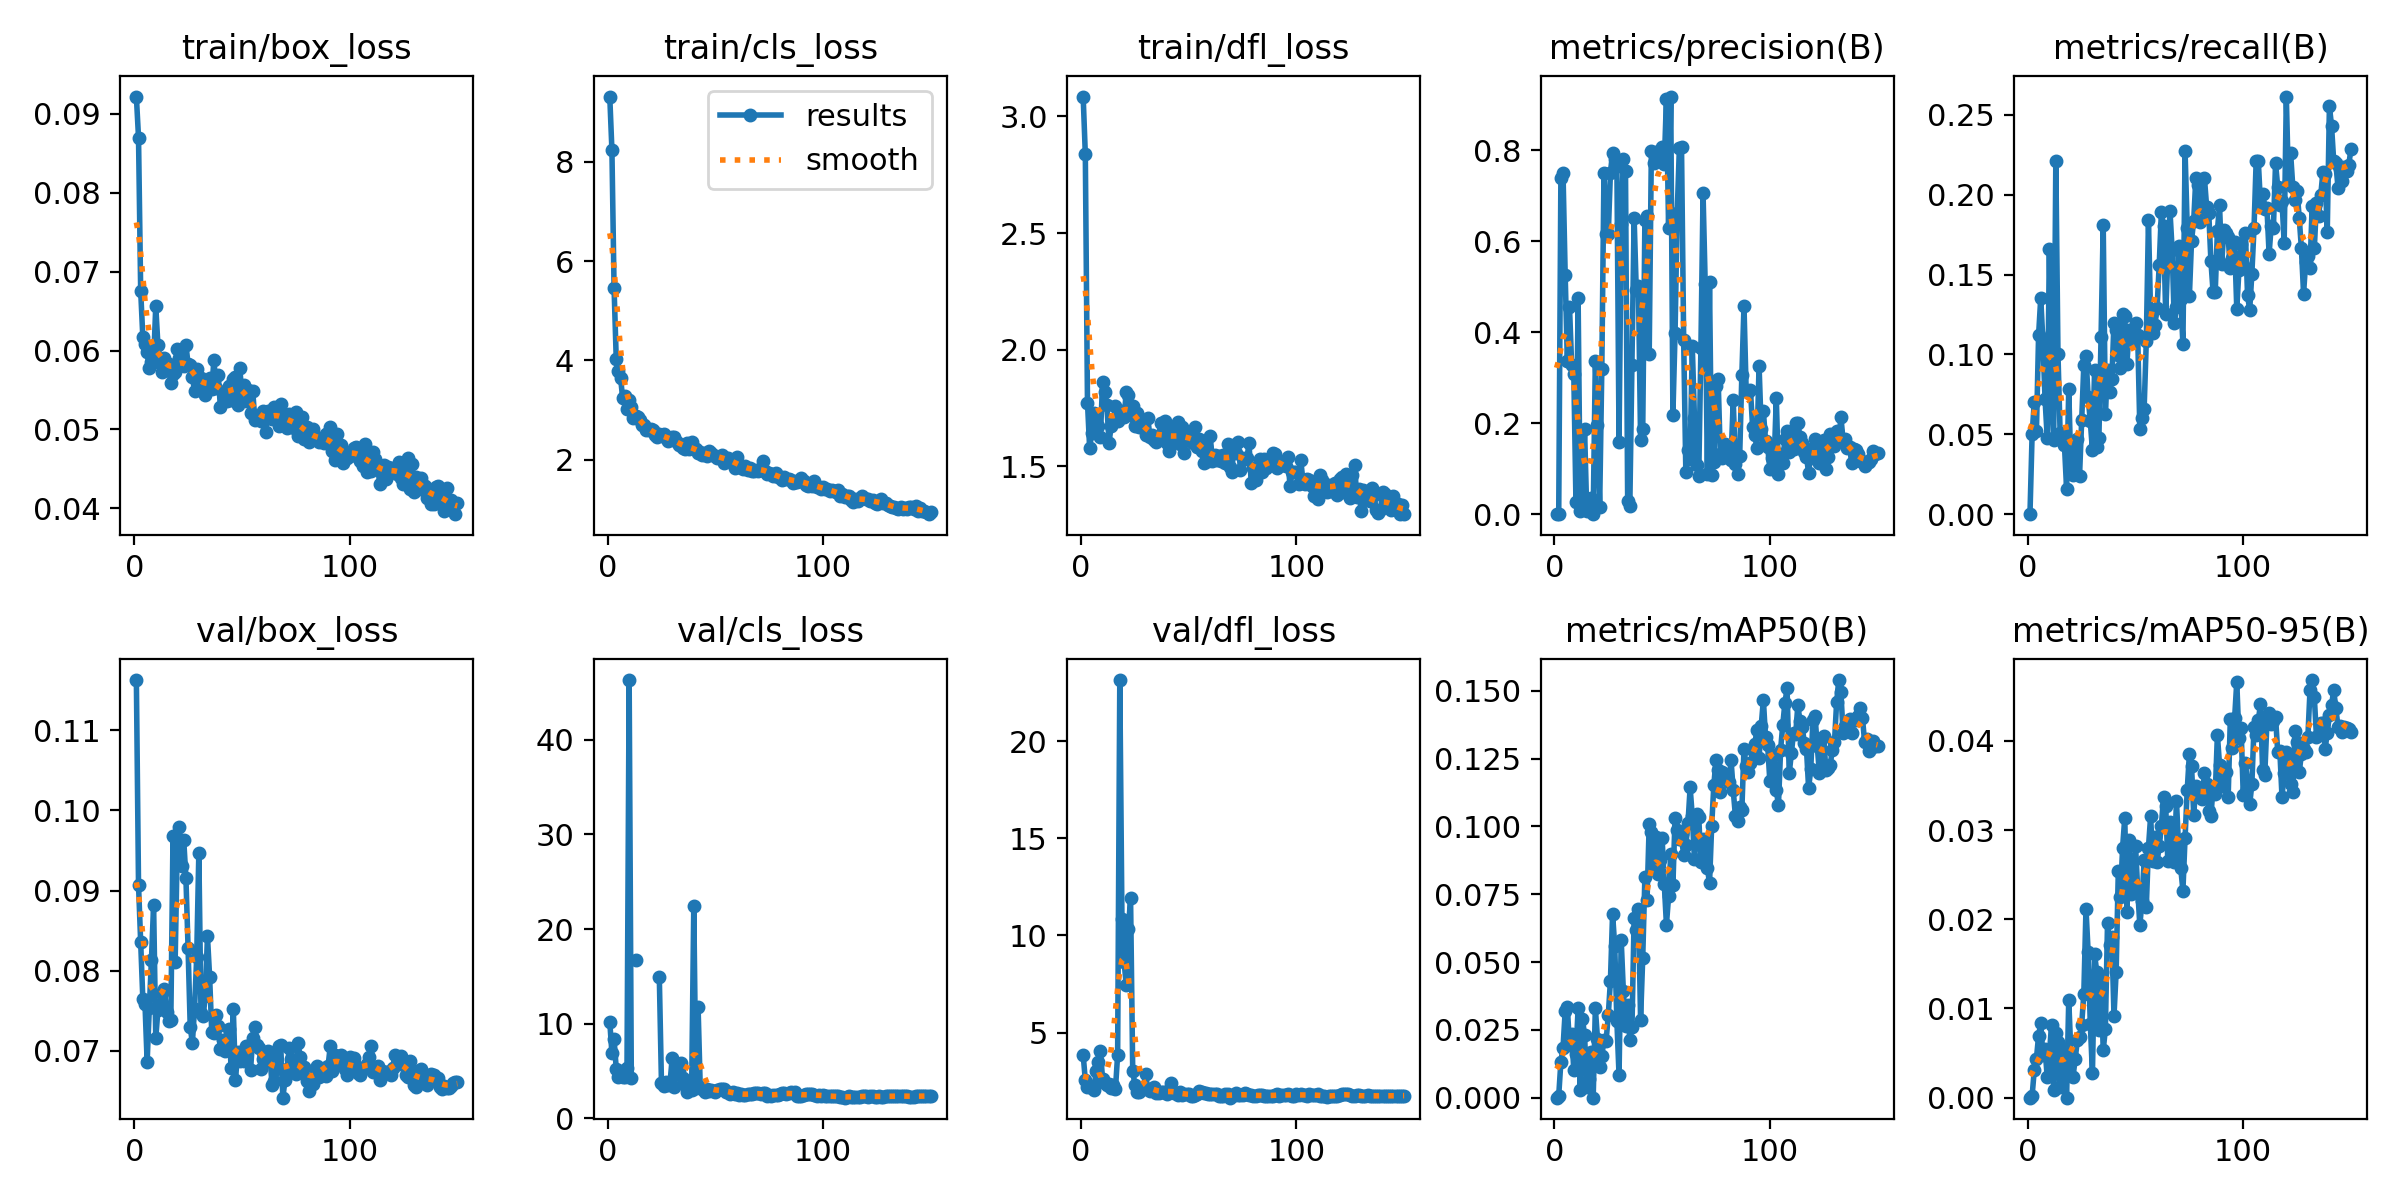

In [29]:
project = yolo_dir/'runs'
name = 'yolo11m_finetuned'
results_path = project / name / "results.png"

display(Image(filename=results_path, width=1000))

We finally get the following resulting metrics:

| Metric | Value |
| --- | --- |
| Precision |  0.279 |
| Recall| 0.191|
| mAP50|      0.197|
| mAP50-95|   0.0654|

Note that this is better in every metric to what we achieved with the smaller model `yolo11n.pt`.